In [1]:
%matplotlib inline

In [62]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [35]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.3
pandas==0.25.3
numpy==1.17.4
torch==1.3.1
sklearn==0.21.0
transformers==2.1.1
matplotlib==3.0.3


In [4]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [5]:
df = pd.read_csv('data/train.csv')
df.shape

(159571, 8)

In [6]:
np.random.seed(42)
df = df.sample(frac=1)
df = df.reset_index(drop=True)

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
1,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
2,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
3,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
4,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


In [8]:
df.comment_text[0]

"Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?"

In [9]:
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df.iloc[[103]][target_columns]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
103,1,1,1,0,1,0


In [10]:
df_train = df[:10000].reset_index(drop=True)
df_val = df[10000:11000].reset_index(drop=True)
df_test = df[11000:13000].reset_index(drop=True)

In [11]:
df_train.shape

(10000, 8)

In [12]:
df_val.shape

(1000, 8)

In [13]:
df_test.shape

(2000, 8)

In [14]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [15]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

I1127 22:16:28.545769 4576552384 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/r.orac/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1127 22:16:28.547996 4576552384 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1127 22:16:29.254769 457655

In [16]:
max_seq = 100

In [17]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.comment_text.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [18]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

In [19]:
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

In [20]:
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

In [138]:
x_train[0]

tensor([[ 0.1020, -0.1540, -0.1991,  ..., -0.0927,  0.9687,  0.1253],
        [ 0.5115,  0.6774,  1.4377,  ...,  1.0570,  0.3752, -0.3614],
        [ 0.0124,  0.1622,  1.1159,  ...,  0.8882,  0.6164, -0.2798],
        ...,
        [ 0.1322,  0.0337,  1.0933,  ..., -0.6233,  0.1783, -1.1930],
        [ 0.0658,  0.0356,  1.0270,  ..., -0.6100,  0.0813, -1.1758],
        [ 0.2795,  0.3124,  0.8268,  ..., -0.6755, -0.0943, -1.2319]])

In [139]:
x_train[0].shape

torch.Size([100, 768])

In [142]:
y_train[0]

tensor([0., 0., 0., 0., 0., 0.])

In [22]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [24]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [25]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [26]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [23]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [27]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.20. Validation loss: 0.09. Elapsed time: 37.81s.
Epoch 2 Train loss: 0.13. Validation loss: 0.07. Elapsed time: 36.39s.
Epoch 3 Train loss: 0.10. Validation loss: 0.07. Elapsed time: 36.37s.
Epoch 4 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 36.62s.
Epoch 5 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 35.92s.
Epoch 6 Train loss: 0.09. Validation loss: 0.07. Elapsed time: 35.42s.
Epoch 7 Train loss: 0.08. Validation loss: 0.06. Elapsed time: 36.55s.
Epoch 8 Train loss: 0.08. Validation loss: 0.06. Elapsed time: 35.41s.
Epoch 9 Train loss: 0.08. Validation loss: 0.07. Elapsed time: 36.03s.
Epoch 10 Train loss: 0.08. Validation loss: 0.07. Elapsed time: 35.94s.


Text(0.5, 1.0, 'Losses')

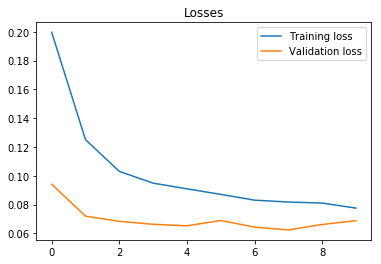

In [37]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [52]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [55]:
y_preds_np

array([[4.31922777e-03, 1.02647872e-08, 7.67312944e-04, 4.82944529e-08,
        5.48943179e-04, 1.47456039e-05],
       [1.93794966e-02, 1.65772087e-06, 4.40812251e-03, 3.24758662e-06,
        4.04525641e-03, 1.62638054e-04],
       [1.14875985e-03, 7.16099610e-11, 1.43278172e-04, 7.72443276e-10,
        9.23425468e-05, 1.27330247e-06],
       ...,
       [3.68908630e-03, 4.57207561e-09, 5.53303165e-04, 2.50337173e-08,
        4.26724349e-04, 8.35142146e-06],
       [9.97485360e-04, 4.76052600e-11, 1.12171409e-04, 5.47074053e-10,
        7.51411499e-05, 8.22096808e-07],
       [8.12641159e-02, 3.14069737e-04, 3.06670386e-02, 2.79268977e-04,
        2.92679444e-02, 3.49535886e-03]])

In [53]:
y_test_np = df_test[target_columns].values

In [60]:
y_test_np[1000:]

array([[1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [74]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
1,severe_toxic,0.966361
4,insult,0.959854
0,toxic,0.954778
3,threat,0.946667
5,identity_hate,0.941165
2,obscene,0.939816


In [82]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

2201

In [83]:
all_labels = df_train[target_columns].count().sum()
all_labels

60000

In [84]:
positive_labels/all_labels

0.03668333333333333

In [102]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [104]:
df_sanity

,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
df_test_targets.sum()

toxic            186
severe_toxic      17
obscene           98
threat             5
insult            96
identity_hate     18
dtype: int64

In [128]:
df_pred_targets.sum()

toxic            91
severe_toxic      0
obscene          43
threat            0
insult           23
identity_hate     0
dtype: int64

In [134]:
df_sanity[df_sanity.toxic > 0][['toxic', 'toxic_pred']]

,toxic,toxic_pred
12,1,0
22,1,0
27,1,0
45,1,1
53,1,1
...,...,...
1964,1,1
1965,1,1
1977,1,0
1984,1,0
